# Multiple Regression

Although the VP is pretty impressed with your predictive model, she thinks you can
do better. To that end, you’ve collected additional data: you know how many hours
each of your users works each day, and whether they have a PhD. You’d like to use this
additional data to improve your model.

Accordingly, you hypothesize a linear model with more independent variables:

$$ \large \textrm{minutes} = \alpha + \beta_1 \textrm{friends} + \beta_2 \textrm{work hours} + \beta_3 \textrm{phd} + \epsilon $$

Obviously, whether a user has a PhD is not a number—but, as we mentioned earlier discussions, we can introduce a dummy variable that equals 1 for users with PhDs and
0 for users without, after which it’s just as numeric as the other variables.

## The Model

Recall that when discussing Simple Linear Regression we fit a model of the form:

$$ \large y_i = \alpha + \beta x_i + \epsilon_i $$

Now imagine that each input $x_i$ is not a single number but rather a vector of $k$ numbers,
$x_{i1}, \dots, x_{ik}$. The multiple (linear) regression model assumes that:

$$ \large y_i = \alpha + \beta_1 x_{i1} + \dots + \beta_k x_{ik} + \epsilon_i $$

In multiple regression the vector of parameters is usually called $β$. We’ll want this to
include the constant term as well, which we can achieve by adding a column of 1s to
our data:

```python
beta = [alpha, beta_1, ..., beta_k]
```
and:
```python
x_i = [1, x_i1, ..., x_ik]
```
Then our model is just:

In [2]:
from typing import List
Vector = List[float]

def dot(v: Vector, w: Vector) -> float:
    """Computes v_1 * w_1 + ... + v_n * w_n"""
    assert len(v) == len(w), "vectors must be same length"

    return sum(v_i * w_i for v_i, w_i in zip(v, w))

In [3]:
def predict(x: Vector, beta: Vector) -> float:
    """assumes that the first element of x is 1"""
    return dot(x, beta)

In this particular case, our independent variable x will be a list of vectors, each of
which looks like this:
```python
[1,    # constant term
 49,   # number of friends
 4,    # work hours per day
 0]    # doesn't have PhD
```

## Further Assumptions of the Least Squares Model

There are a couple of further assumptions that are required for this model (and our
solution) to make sense.

The first is that the columns of x are *linearly independent*—that there’s no way to write
any one as a weighted sum of some of the others (or perfectly predict one column based on the other columns). If this assumption fails, it’s impossible
to estimate `beta`. To see this in an extreme case, imagine we had an extra field
`num_acquaintances` in our data that for every user was exactly equal to `num_friends`.

Then, starting with any `beta`, if we add any amount to the `num_friends` coefficient
and subtract that same amount from the `num_acquaintances` coefficient, the model’s
predictions will remain unchanged. This means that there’s no way to find the coefficient
for `num_friends`. (Usually violations of this assumption won’t be so obvious.)

The second important assumption is that the columns of `x` are all uncorrelated with
the errors $\epsilon$. If this fails to be the case, our estimates of `beta` will be systematically
wrong.

For instance, earlier we built a simple linear regression model that predicted that each additional
friend was associated with an extra 0.90 daily minutes on the site.

Imagine it’s also the case that:
- People who work more hours spend less time on the site.
- People with more friends tend to work more hours.

That is, imagine that the “actual” model is:

$$ \large \textrm{minutes} = \alpha + \beta_1 \textrm{friends} + \beta_2 \textrm{work hours} + \epsilon $$

where $\beta_2$ is negative, and that work hours and friends are positively correlated. In that
case, when we minimize the errors of the single-variable model:

$$ \large \textrm{minutes} = \alpha + \beta_1 \textrm{friends} + \epsilon $$

we will underestimate $\beta_1$ (since $\beta_2$, a negative value, is missing, so $\beta_1$ alone has to be lower than what it should be to account for the loss of the negative term $\beta_2 \textrm{work hours}$).

Think about what would happen if we made predictions using the single-variable
model with the “actual” value of $\beta_1$. (That is, the value that arises from minimizing
the errors of what we called the “actual” model.)

The predictions would tend to be
way too large for users who work many hours and a little too large for users who
work few hours, because $\beta_2 < 0$ and we “forgot” to include it. 

Because work hours is
positively correlated with number of friends, this means the predictions tend to be
way too large for users with many friends, and only slightly too large for users with
few friends.

The result of this is that we can reduce the errors (in the single-variable model) by
decreasing our estimate of $\beta_1$, which means that the error-minimizing $\beta_1$ is smaller
than the “actual” value. 

That is, in this case the single-variable least squares solution is
biased to underestimate $\beta_1$. And, in general, whenever the independent variables are
correlated with the errors like this, our least squares solution will give us a biased estimate
of $\beta_1$.

## Fitting the Model

As we did in the simple linear regression model, we’ll choose `beta` to minimize the sum of
squared errors. Finding an exact solution is not simple to do by hand, which means
we’ll need to use an optimizer (minimizer). Again we’ll want to minimize the sum of the
squared errors. The error function is almost identical to the one we used in the simple linear regression model, except that instead of expecting parameters `[alpha, beta]` it will take a vector
of arbitrary length:

In [4]:
def error(x: Vector, y: float, beta: Vector) -> float:
    return y - predict(x, beta)

def squared_error(x: Vector, y: float, beta: Vector) -> float:
    return error(x, y, beta) ** 2

def sum_of_sqerrors(xs: List[Vector], ys: Vector, beta: Vector) -> float:
    return sum(squared_error(x_i, y_i, beta) for x_i, y_i in zip(xs, ys))

x = [1, 2, 3]
y = 30
beta = [4, 4, 4]  # so prediction = 4 + 8 + 12 = 24

print(error(x, y, beta))         # 30 - 24 = 6
print(squared_error(x, y, beta)) # 6^2 = 36

6
36


At this point, we’re ready to find the optimal `beta` using an optimizer. Let’s first
write out a `least_squares_fit` function that can work with any dataset:

In [5]:
import random
from scipy.optimize import minimize

def least_squares_fit(xs: List[Vector], ys: Vector) -> Vector:
    """
    Find the beta that minimizes the sum of squared errors
    assuming the model y = dot(x, beta).
    """
    def object_fun (beta: Vector):
        return sum_of_sqerrors (xs, ys, beta)
    
    # Start with a random guess
    guess = [random.random() for _ in xs[0]]

    optim = minimize (object_fun, guess, method='BFGS')
    
    return optim.x

We can then apply that to our data:

In [6]:
inputs: List[Vector] = [[1.,49,4,0],[1,41,9,0],[1,40,8,0],[1,25,6,0],[1,21,1,0],[1,21,0,0],[1,19,3,0],[1,19,0,0],[1,18,9,0],[1,18,8,0],[1,16,4,0],[1,15,3,0],[1,15,0,0],[1,15,2,0],[1,15,7,0],[1,14,0,0],[1,14,1,0],[1,13,1,0],[1,13,7,0],[1,13,4,0],[1,13,2,0],[1,12,5,0],[1,12,0,0],[1,11,9,0],[1,10,9,0],[1,10,1,0],[1,10,1,0],[1,10,7,0],[1,10,9,0],[1,10,1,0],[1,10,6,0],[1,10,6,0],[1,10,8,0],[1,10,10,0],[1,10,6,0],[1,10,0,0],[1,10,5,0],[1,10,3,0],[1,10,4,0],[1,9,9,0],[1,9,9,0],[1,9,0,0],[1,9,0,0],[1,9,6,0],[1,9,10,0],[1,9,8,0],[1,9,5,0],[1,9,2,0],[1,9,9,0],[1,9,10,0],[1,9,7,0],[1,9,2,0],[1,9,0,0],[1,9,4,0],[1,9,6,0],[1,9,4,0],[1,9,7,0],[1,8,3,0],[1,8,2,0],[1,8,4,0],[1,8,9,0],[1,8,2,0],[1,8,3,0],[1,8,5,0],[1,8,8,0],[1,8,0,0],[1,8,9,0],[1,8,10,0],[1,8,5,0],[1,8,5,0],[1,7,5,0],[1,7,5,0],[1,7,0,0],[1,7,2,0],[1,7,8,0],[1,7,10,0],[1,7,5,0],[1,7,3,0],[1,7,3,0],[1,7,6,0],[1,7,7,0],[1,7,7,0],[1,7,9,0],[1,7,3,0],[1,7,8,0],[1,6,4,0],[1,6,6,0],[1,6,4,0],[1,6,9,0],[1,6,0,0],[1,6,1,0],[1,6,4,0],[1,6,1,0],[1,6,0,0],[1,6,7,0],[1,6,0,0],[1,6,8,0],[1,6,4,0],[1,6,2,1],[1,6,1,1],[1,6,3,1],[1,6,6,1],[1,6,4,1],[1,6,4,1],[1,6,1,1],[1,6,3,1],[1,6,4,1],[1,5,1,1],[1,5,9,1],[1,5,4,1],[1,5,6,1],[1,5,4,1],[1,5,4,1],[1,5,10,1],[1,5,5,1],[1,5,2,1],[1,5,4,1],[1,5,4,1],[1,5,9,1],[1,5,3,1],[1,5,10,1],[1,5,2,1],[1,5,2,1],[1,5,9,1],[1,4,8,1],[1,4,6,1],[1,4,0,1],[1,4,10,1],[1,4,5,1],[1,4,10,1],[1,4,9,1],[1,4,1,1],[1,4,4,1],[1,4,4,1],[1,4,0,1],[1,4,3,1],[1,4,1,1],[1,4,3,1],[1,4,2,1],[1,4,4,1],[1,4,4,1],[1,4,8,1],[1,4,2,1],[1,4,4,1],[1,3,2,1],[1,3,6,1],[1,3,4,1],[1,3,7,1],[1,3,4,1],[1,3,1,1],[1,3,10,1],[1,3,3,1],[1,3,4,1],[1,3,7,1],[1,3,5,1],[1,3,6,1],[1,3,1,1],[1,3,6,1],[1,3,10,1],[1,3,2,1],[1,3,4,1],[1,3,2,1],[1,3,1,1],[1,3,5,1],[1,2,4,1],[1,2,2,1],[1,2,8,1],[1,2,3,1],[1,2,1,1],[1,2,9,1],[1,2,10,1],[1,2,9,1],[1,2,4,1],[1,2,5,1],[1,2,0,1],[1,2,9,1],[1,2,9,1],[1,2,0,1],[1,2,1,1],[1,2,1,1],[1,2,4,1],[1,1,0,1],[1,1,2,1],[1,1,2,1],[1,1,5,1],[1,1,3,1],[1,1,10,1],[1,1,6,1],[1,1,0,1],[1,1,8,1],[1,1,6,1],[1,1,4,1],[1,1,9,1],[1,1,9,1],[1,1,4,1],[1,1,2,1],[1,1,9,1],[1,1,0,1],[1,1,8,1],[1,1,6,1],[1,1,1,1],[1,1,1,1],[1,1,5,1]]

daily_minutes_good = [68.77,51.25,52.08,38.36,44.54,57.13,51.4,41.42,31.22,34.76,54.01,38.79,47.59,49.1,27.66,41.03,
                     36.73,48.65,28.12,46.62,35.57,32.98,35,26.07,23.77,39.73,40.57,31.65,31.21,36.32,20.45,21.93,26.02,
                     27.34,23.49,46.94,30.5,33.8,24.23,21.4,27.94,32.24,40.57,25.07,19.42,22.39,18.42,46.96,23.72,26.41,
                     26.97,36.76,40.32,35.02,29.47,30.2,31,38.11,38.18,36.31,21.03,30.86,36.07,28.66,29.08,37.28,15.28,
                     24.17,22.31,30.17,25.53,19.85,35.37,44.6,17.23,13.47,26.33,35.02,32.09,24.81,19.33,28.77,24.26,31.98,
                     25.73,24.86,16.28,34.51,15.23,39.72,40.8,26.06,35.76,34.76,16.13,44.04,18.03,19.65,32.62,35.59,39.43,
                     14.18,35.24,40.13,41.82,35.45,36.07,43.67,24.61,20.9,21.9,18.79,27.61,27.21,26.61,29.77,20.59,27.53,
                     13.82,33.2,25,33.1,36.65,18.63,14.87,22.2,36.81,25.53,24.62,26.25,18.21,28.08,19.42,29.79,32.8,35.99,
                     28.32,27.79,35.88,29.06,36.28,14.1,36.63,37.49,26.9,18.58,38.48,24.48,18.95,33.55,14.24,29.04,32.51,
                     25.63,22.22,19,32.73,15.16,13.9,27.2,32.01,29.27,33,13.74,20.42,27.32,18.23,35.35,28.48,9.08,24.62,
                     20.12,35.26,19.92,31.02,16.49,12.16,30.7,31.22,34.65,13.13,27.51,33.2,31.57,14.1,33.42,17.44,10.12,
                     24.42,9.82,23.39,30.93,15.03,21.67,31.09,33.29,22.61,26.89,23.48,8.38,27.81,32.35,23.84]


beta = least_squares_fit(inputs, daily_minutes_good)
print(beta)

[30.57901802  0.97250517 -1.86503637  0.92320089]


In practice, you wouldn’t estimate a linear regression using an optimizer; you’d get
the exact coefficients using linear algebra and calculus techniques that are beyond the scope of this
class. If you did so, you’d find the equation:

$$ \textrm{minutes} = 30.58 + 0.972 \textrm{ friends} − 1.87 \textrm{ work hours} + 0.923 \textrm{ phd} $$

which is pretty close to what we found.

## Interpreting the Model

You should think of the coefficients of the model as representing all-else-being-equal
estimates of the impacts of each factor.
- All else being equal, each additional friend corresponds to an extra minute spent on the site each day.
- All else being equal, each additional hour in a user’s workday corresponds to about two fewer minutes spent on the site each day.
- All else being equal, having a PhD is associated with spending an extra minute on the site each day.

What this doesn’t (directly) tell us is anything about the interactions among the variables.
It’s possible that the effect of work hours is different for people with many
friends than it is for people with few friends. This model doesn’t capture that. 
One way to handle this case is to introduce a new variable that is the *product* of “friends”
and “work hours.”

Or it’s possible that the more friends you have, the more time you spend on the site
up to a point, after which further friends cause you to spend less time on the site.
(Perhaps with too many friends the experience is just too overwhelming?) We could
try to capture this in our model by adding another variable that’s the square of the
number of friends.

Once we start adding variables, we need to worry about whether their coefficients
“matter.” There are no limits to the numbers of products, logs, squares, and higher
powers we could add.

## Goodness of Fit

Again we can look at the R-squared:



x = [-100, -90, -80, -70, -60, -50, -40, -30, -20, -10, 0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
y = [-305, -275, -245, -215, -185, -155, -125, -95, -65, -35, -5, 25, 55, 85, 115, 145, 175, 205, 235, 265, 295]
alpha, beta = (-5.0, 3.0)
alpha = 22.947552413468976
beta  = 0.9038659456058724


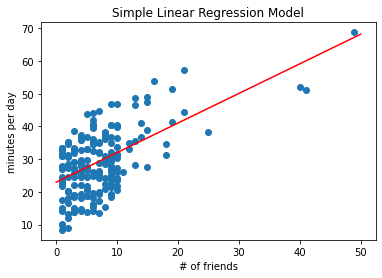

rsq    = 0.3291078377836305
rsq_sk = 0.32910783778362984
r      = 0.57367921156656
r^2    = 0.3291078377836299
22.947552413468976
0.9038659456058724
[22.94755232  0.90386594]


In [7]:
from Week07T import total_sum_of_squares

def multiple_r_squared(xs: List[Vector], ys: Vector, beta: Vector) -> float:
    sum_of_squared_errors = sum(error(x, y, beta) ** 2
                                for x, y in zip(xs, ys))
    return 1.0 - sum_of_squared_errors / total_sum_of_squares(ys)

which has now increased to 0.68:

In [7]:
print(multiple_r_squared(inputs, daily_minutes_good, beta))

0.6800110181375771


Keep in mind, however, that adding new variables to a regression will *necessarily*
increase the R-squared. After all, the simple regression model is just the special case
of the multiple regression model where the coefficients on “work hours” and “PhD”
both equal 0. The optimal multiple regression model will necessarily have an error at
least as small as that one.

Because of this, in a multiple regression, we also need to look at the *standard errors* of
the coefficients, which measure how certain we are about our estimates of each $\beta_i$.
The regression as a whole may fit our data very well, but if some of the independent
variables are correlated (or irrelevant), their coefficients might not *mean* much.

The typical approach to measuring these errors starts with another assumption—that
the errors $\epsilon_i$ are independent normal random variables with mean 0 and some shared
(unknown) standard deviation $\sigma$. In that case, we (or, more likely, our statistical software)
can use some linear algebra to find the standard error of each coefficient. The
larger it is, the less sure our model is about that coefficient. Unfortunately, we’re not
set up to do that kind of linear algebra from scratch.

## Digression: The Bootstrap

Imagine that we have a sample of $n$ data points, generated by some (unknown to us)
distribution:

```python
data = get_sample(num_points=n)
```

Earlier in the semester, we wrote a function that could compute the `median` of the sample,
which we can use as an estimate of the median of the distribution itself.

But how confident can we be about our estimate? If all the data points in the sample
are very close to 100, then it seems likely that the actual median is close to 100. If
approximately half the data points in the sample are close to 0 and the other half are
close to 200, then we can’t be nearly as certain about the median.

If we could repeatedly get new samples, we could compute the medians of many samples
and look at the distribution of those medians. Often we can’t. In that case we can
*bootstrap* new datasets by choosing *n* data points *with replacement* from our data.
And then we can compute the medians of those synthetic datasets:

In [11]:
from typing import TypeVar, Callable

X = TypeVar('X')        # Generic type for data
Stat = TypeVar('Stat')  # Generic type for "statistic"

def bootstrap_sample(data: List[X]) -> List[X]:
    """randomly samples len(data) elements with replacement"""
    return [random.choice(data) for _ in data]

def bootstrap_statistic(data: List[X],
                        stats_fn: Callable[[List[X]], Stat],
                        num_samples: int) -> List[Stat]:
    """evaluates stats_fn on num_samples bootstrap samples from data"""
    return [stats_fn(bootstrap_sample(data)) for _ in range(num_samples)]

For example, consider the two following datasets:

In [12]:
# 101 points all very close to 100
close_to_100 = [99.5 + random.random() for _ in range(101)]

# 101 points, 50 of them near 0, 50 of them near 200
far_from_100 = ([99.5 + random.random()] +
                [random.random() for _ in range(50)] +
                [200 + random.random() for _ in range(50)])

If you compute the medians of the two datasets, both will be very close to 100. However,
if you look at:

In [13]:
from statistics import median, stdev

medians_close = bootstrap_statistic(close_to_100, median, 100)
print(medians_close)

[100.07695233595796, 100.04096865985923, 100.0732302247859, 100.0732302247859, 99.9031154752554, 99.94477231158407, 99.82821568533592, 100.01662771062595, 99.95308613140143, 100.04096865985923, 100.07695233595796, 99.95890526554467, 99.95308613140143, 100.12360169937197, 100.04096865985923, 100.1264868989267, 99.92833829394239, 100.01662771062595, 100.04096865985923, 100.05128683971144, 100.0732302247859, 99.94092482987332, 100.06279397921298, 100.05128683971144, 99.97219856368471, 100.01662771062595, 100.00476710359703, 100.0732302247859, 100.01662771062595, 100.1264868989267, 100.06279397921298, 99.94477231158407, 99.95890526554467, 99.95890526554467, 100.00476710359703, 100.0732302247859, 100.04096865985923, 100.05128683971144, 99.95308613140143, 100.12545025949998, 99.88469254361506, 100.0732302247859, 100.05128683971144, 100.0732302247859, 99.95308613140143, 99.95890526554467, 100.0732302247859, 100.01662771062595, 99.97219856368471, 100.00476710359703, 99.92833829394239, 100.1254

you will mostly see numbers really close to 100. But if you look at:

In [14]:
medians_far = bootstrap_statistic(far_from_100, median, 100)
print(medians_far)

[200.06960447578828, 200.06927071443147, 0.9023183165976639, 200.0028814399315, 200.06927071443147, 0.9048673083118102, 200.0307730364306, 200.0307730364306, 200.23331479260912, 0.8864449752916473, 200.12713378424655, 0.9048673083118102, 0.8718848350182556, 200.06927071443147, 100.11670099633042, 200.0028814399315, 100.11670099633042, 200.11869799256763, 200.06927071443147, 200.06960447578828, 200.25791549634286, 0.9656962396104048, 200.08427261503604, 200.23331479260912, 200.23331479260912, 200.06960447578828, 0.9483290508646044, 200.0307730364306, 200.08427261503604, 0.9586187975220156, 0.9586187975220156, 0.8959158984869848, 200.06927071443147, 200.06927071443147, 0.9023183165976639, 0.9483290508646044, 0.9483290508646044, 200.0307730364306, 200.203880548764, 0.9586187975220156, 200.0028814399315, 200.0307730364306, 0.6839939579556614, 0.8864449752916473, 200.0028814399315, 0.9483290508646044, 0.8959158984869848, 200.30217167872487, 0.8214917330448126, 0.9586187975220156, 0.95861879

you will see a lot of numbers close to 0 and a lot of numbers close to 200.

The standard deviation of the first set of medians is close to 0, while that of the
second set of medians is close to 100:

In [15]:
print(stdev(medians_close))
print(stdev(medians_far))

0.06293632405439407
97.56117694174355


(This extreme a case would be pretty easy to figure out by manually inspecting the
data, but in general that won’t be true.)